In [118]:
from pathlib import Path
from functools import partial

import numpy as np
from skfda.representation.grid import FDataGrid
from skfda.representation.basis import BSplineBasis
from skfda.preprocessing.dim_reduction import FPCA
from skfda.exploratory.stats import (std, fisher_rao_karcher_mean)
from skfda.preprocessing.registration import FisherRaoElasticRegistration
from skfda.ml.regression import LinearRegression

from gplearn.genetic import SymbolicRegressor
from gplearn.functions import make_function
from jax import (grad, jit, Array, vjp)
from jax.lax import cond
import jax.numpy as jnp
from scipy.interpolate import (make_lsq_spline, BSpline, Akima1DInterpolator)
from scipy.integrate import cumulative_trapezoid
from math import (gamma, factorial)
from statsmodels.nonparametric.kernel_regression import KernelReg
import statsmodels.api as sm
import polars as pl
import plotly.express as px

# Exploratory Data Analysis and Feature Engineering

We have data on model_year, calendar_time, and advertised_inventory.

In [109]:
# Import data
mixed_years_path = Path("..", "raw_data", "model_year_vs_calendar_time", "model_year_vs_calendar_time.csv")
mixed_years = pl.scan_csv(
    source=mixed_years_path,
)
# View head of data
mixed_years.collect().head()

shape: (5, 6)
┌────────────┬───────────────┬─────────────────┬─────────────────┬────────────────┬────────────────┐
│ model_year ┆ calendar_time ┆ advertised_inve ┆ model_year_is_p ┆ model_year_is_ ┆ model_year_is_ │
│ ---        ┆ ---           ┆ ntory           ┆ revious_calenda ┆ calendar_year  ┆ next_calendar_ │
│ i64        ┆ f64           ┆ ---             ┆ …               ┆ ---            ┆ ye…            │
│            ┆               ┆ f64             ┆ ---             ┆ i64            ┆ ---            │
│            ┆               ┆                 ┆ i64             ┆                ┆ i64            │
╞════════════╪═══════════════╪═════════════════╪═════════════════╪════════════════╪════════════════╡
│ 2022       ┆ 2020.5        ┆ 0.0             ┆ 0               ┆ 0              ┆ 0              │
│ 2022       ┆ 2020.9        ┆ 0.0             ┆ 0               ┆ 0              ┆ 0              │
│ 2022       ┆ 2022.420572   ┆ 935.612174      ┆ 0               ┆ 1              ┆ 0              │
│ 2022       ┆ 2022.441428   ┆ 928.768412      ┆ 0               ┆ 1              ┆ 0              │
│ 2022       ┆ 2022.462284   ┆ 920.898087      ┆ 0               ┆ 1              ┆ 0              │
└────────────┴───────────────┴─────────────────┴─────────────────┴────────────────┴────────────────┘

Create a new variable called yr_diff to represent how far ahead the calendar_time is from the model_year.

In [110]:
mixed_years = (
    mixed_years
        .select(
            "model_year",
            # Use the midpoint rule.
            (pl.col("calendar_time") - (pl.col("model_year") + 6/12)).alias("yr_diff"),
            "advertised_inventory"
        )
)

# Also, pad in some more 0s for easier modeling later.
mixed_years = (mixed_years
    .collect()
    .vstack(
        pl.DataFrame(
            {
                "model_year": [2022]*10, 
                "yr_diff": np.linspace(2.05, 2.19, 10),
                "advertised_inventory": [0.0]*10,
            }
        )
    )
    .vstack(
        pl.DataFrame(
            {
                "model_year": [2023]*11, 
                "yr_diff": [1.95, 2.0, 2.05, -1.65, -1.70, -1.75, -1.8, -1.85, -1.9, -1.95, 2.19],
                "advertised_inventory": [0.0]*11,
            }
        )
    )
    .vstack(
        pl.DataFrame(
            {
                "model_year": [2024], 
                "yr_diff": [2.19],
                "advertised_inventory": [0.0],
            }
        )
    )
    .vstack(
        pl.DataFrame(
            {
                "model_year": [2025], 
                "yr_diff": [2.19],
                "advertised_inventory": [0.0],
            }
        )
    )
    .lazy()
)

Except for some fluctations in year-to-year amplitudes, the pattern of inventory rise and fall for different model years appears remarkably consistent.  Inventories for each model year peak around July 1st of the same calendar year.

In [111]:
x = mixed_years.select("yr_diff").collect().to_series().to_numpy()
y = mixed_years.select("advertised_inventory").collect().to_series().to_numpy()
color = mixed_years.select(pl.col("model_year").cast(pl.Utf8)).collect().to_series().to_numpy()

px.scatter(
    x=x,
    y=y,
    color=color,
    title="The Rise and Fall of Vehicle Inventories",
    labels={
        "x": "calendar_time - (model_year + 6/12) (years)",
        "y": "Advertised Vehicle Inventory (thousands)",
        "color": "Model Year"
    }
)

/home/justin/bin/mambaforge/envs/justins_room/lib/python3.11/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



# Predict the Average Inventory Curve

We will combine our data from the different model years to predict an average inventory curve that can be differentiated and used for prior model years. 

In [132]:
# For each model year that we have data (2022 through 2025),
# fit a separate spline regression.  Do this so that monthly
# inventory counts can be predicted despite not having
# direct access to this information.  (The only information
# that we have to go on is the graph from www.spglobal.com/mobility)
# Use the splines to interpolate values.  

model_yr_range = range(2022, 2026, 1)
inventory_model = dict.fromkeys(model_yr_range)

# Create some evenly space yr_diffs for evaluating each model.
# These same yr_diffs can be used for other model years
# to compare apples to apples.
step = 1.0/1200.0
a = -2.0
b = 2.19

yr_diffs_for_prediction = np.linspace(a, b, num=int((b - a)/step + 1))

# For each year, train and predict on only some of the yr_diffs.
# Actually, predict for all of the yr_diffs first and then
# go back and change predictions to NAs for predictions
# based on yr_diffs outside of the yr_diff_filter.
yr_diff_filter = {
    2022: (-0.079428, 2.19),
    2023: (-2.0, 2.1),
    2024: (-2.0, 0.283906),
    2025: (-2.0, -0.716094)
}

# Create a data-frame to store the predictions from each model.
mixed_years_2 = pl.DataFrame()

# Make a model for each model_year and fit the model.
for yr in model_yr_range:
    # For the current yr, get the yr_diffs to train and predict on.
    a, b = yr_diff_filter[yr]

    # Get the yr_diffs for predicting.
    # yr_diffs_for_prediction_current = yr_diffs_for_prediction[(yr_diffs_for_prediction >= a) & (yr_diffs_for_prediction <= b)]
    
    # Get the yr_diffs for training.
    yr_diffs_for_training = (mixed_years
        .filter(pl.col("model_year") == yr)
        .sort(by=pl.col("yr_diff"))
        .select("yr_diff")
        .collect()
        .to_series()
        .to_numpy()
    )

    # Get the response values for training.
    y = (mixed_years
        .filter(pl.col("model_year") == yr)
        .sort(by=pl.col("yr_diff"))
        .select("advertised_inventory")
        .collect()
        .to_series()
        .to_numpy()
    )
    
    # Prepare to fit model.
    # Fit model.
    current_yr_inventory_model = Akima1DInterpolator(
        x=yr_diffs_for_training,
        y=y,
        method="makima",
        extrapolate=True
    )

    # Get the predictions.
    preds = current_yr_inventory_model(yr_diffs_for_prediction)

    # Change some of the predictions to missing values 
    # if they are from extrapolating yr_diffs.
    preds = np.where(
        (yr_diffs_for_prediction < a) | (yr_diffs_for_prediction > b),
        np.nan,
        preds
    )

    # Replace negative values generated by the spline regression.
    # (I cannot figure out how to put constraints on the spline regression
    # other than to just fix the predictions like I do here.)
    preds = np.where(preds < 0, 0, preds)

    # Save the fitted model.
    inventory_model[yr] = current_yr_inventory_model

    # Put the predictions from current_yr_inventory_model into a new data-frame.
    mixed_years_current_preds = pl.LazyFrame(
        data={
            "yr_diff": yr_diffs_for_prediction,
            "model_year": [yr]*len(yr_diffs_for_prediction),
            "predicted_inventory": preds
        },
        schema={
            "yr_diff": pl.Float64,
            "model_year": pl.Int32,
            "predicted_inventory": pl.Float64
        }
    )
    
    # Save mixed_years_current_preds for the current model_year.
    mixed_years_2 = (mixed_years_2
        .vstack(mixed_years_current_preds.collect())     
    )

# Make it lazy.
mixed_years_2 = (mixed_years_2
    .sort(by=["model_year", "yr_diff"])
    .lazy()
)

## Plots

In [116]:
fig = px.scatter()
for yr in model_yr_range:
    # Make a plot of the original training data alongside the predictions.
    x_even = (mixed_years_2
        .filter(pl.col("model_year") == yr)
        .select("yr_diff")
        .collect()
        .to_series()
    )

    y_pred = (mixed_years_2
        .filter(pl.col("model_year") == yr)
        .select("predicted_inventory")
        .collect()
        .to_series()
    )

    fig.add_scatter(
        x=x_even,
        y=y_pred,
        mode="markers",
        name=f"{yr} Predicted"
    )

    x_original = (mixed_years
        .filter(pl.col("model_year") == yr)
        .select("yr_diff")
        .collect()
        .to_series()
    )

    y_act = (mixed_years
        .filter(pl.col("model_year") == yr)
        .select("advertised_inventory")
        .collect()
        .to_series()
    )

    fig.add_scatter(
        x=x_original,
        y=y_act,
        mode="markers",
        name=f"{yr} Actual"
    )

    # https://plotly.com/python/figure-labels/
    fig.update_layout(
        title=dict(text="Curve Fitting for Different Model Years"),
        xaxis=dict(
            title=dict(
                text="calendar_time - (model_year + 6/12) (years)"
            )
        ),
        yaxis=dict(
            title=dict(
                text="Advertised Vehicle Inventory (thousands)"
            )
        )
    )

fig.show()

# Simple Scaling for Imputation

In [114]:
ends = (mixed_years_2
    .filter(pl.col("predicted_inventory").is_not_nan())
    .filter(
        (
            (pl.col("model_year") == 2022) & (pl.col("yr_diff") == pl.col("yr_diff").min().over("model_year"))
        )
        |
        (
            (pl.col("model_year") == 2024) & (pl.col("yr_diff") == pl.col("yr_diff").max().over("model_year"))
        )
        |
        (
            (pl.col("model_year") == 2025) & (pl.col("yr_diff") == pl.col("yr_diff").max().over("model_year"))
        )
    )
)

ends.collect()

shape: (3, 3)
┌───────────┬────────────┬─────────────────────┐
│ yr_diff   ┆ model_year ┆ predicted_inventory │
│ ---       ┆ ---        ┆ ---                 │
│ f64       ┆ i32        ┆ f64                 │
╞═══════════╪════════════╪═════════════════════╡
│ -0.078785 ┆ 2022       ┆ 935.574723          │
│ 0.283788  ┆ 2024       ┆ 1926.95002          │
│ -0.716411 ┆ 2025       ┆ 1169.16697          │
└───────────┴────────────┴─────────────────────┘

In [127]:
ratios = (ends
    .join(
        other=(mixed_years_2
        ),
        on=["yr_diff"]
    )
    .filter((pl.col("predicted_inventory_right").is_not_nan()))
    .with_columns(
        (pl.col("predicted_inventory") / pl.col("predicted_inventory_right")).alias("predicted_inventory_right_ratio")
    )
    .filter(pl.col("predicted_inventory_right_ratio") != 1)
    .select("model_year", "model_year_right", "predicted_inventory_right_ratio")
    .sort(by="model_year")
)

ratios.collect()

shape: (7, 3)
┌────────────┬──────────────────┬─────────────────────────────────┐
│ model_year ┆ model_year_right ┆ predicted_inventory_right_rati… │
│ ---        ┆ ---              ┆ ---                             │
│ i32        ┆ i32              ┆ f64                             │
╞════════════╪══════════════════╪═════════════════════════════════╡
│ 2022       ┆ 2023             ┆ 0.594405                        │
│ 2022       ┆ 2024             ┆ 0.36869                         │
│ 2024       ┆ 2022             ┆ 2.502214                        │
│ 2024       ┆ 2023             ┆ 1.618999                        │
│ 2025       ┆ 2022             ┆ 3.071791                        │
│ 2025       ┆ 2023             ┆ 2.287845                        │
│ 2025       ┆ 2024             ┆ 1.150884                        │
└────────────┴──────────────────┴─────────────────────────────────┘

In [ ]:
# # imputations = 
# a, b = yr_diff_filter[2022]

# # Get the yr_diffs for predicting.
# yr_diffs_for_prediction_current = yr_diffs_for_prediction[(yr_diffs_for_prediction >= a) & (yr_diffs_for_prediction <= b)]

# (mixed_years_2
#     .filter(
#         (pl.col("model_year") == 2022)
#         &
#         (yr_diffs < ends.filter(pl.col("model_year") == 2022).select("yr_diff").collect().item())
#     )  
#     .collect()      
# )

shape: (0, 3)
┌─────────┬────────────┬─────────────────────┐
│ yr_diff ┆ model_year ┆ predicted_inventory │
│ ---     ┆ ---        ┆ ---                 │
│ f64     ┆ i32        ┆ f64                 │
╞═════════╪════════════╪═════════════════════╡
└─────────┴────────────┴─────────────────────┘

In [ ]:
# yr_diffs_for_prediction[yr_diffs_for_prediction < ends.filter(pl.col("model_year") == 2022).select("yr_diff").collect().item()]

array([-3.        , -2.99916655, -2.9983331 , ..., -0.08126129,
       -0.08042784, -0.07959439], shape=(3505,))

# Functional Data Analysis

In [42]:
data_matrix = np.array(
    list(
        (mixed_years_2
            .filter(
                (pl.col("model_year") == yr) & 
                (pl.col("yr_diff") <= ends.filter(pl.col("model_year") == 2024).select("yr_diff").collect().item())
            )
            .select("predicted_inventory")
            .collect()
            .to_series()
            .to_numpy()
            .T
        ) for yr in [2023, 2024]
    )
)

grid_points = (mixed_years_2
    .filter(
        (pl.col("model_year") == 2024) & 
        (pl.col("yr_diff") <= ends.filter(pl.col("model_year") == 2024).select("yr_diff").collect().item())
    )
    .select("yr_diff")
    .collect()
    .to_series()
    .to_numpy()
)

# Create a FDataGrid object for use in functional data analysis.
fd_grid_obj_1 = FDataGrid(
    data_matrix=data_matrix,
    grid_points=grid_points
)

In [43]:
mean_inventory = fisher_rao_karcher_mean(
    fdatagrid=fd_grid_obj_1
)

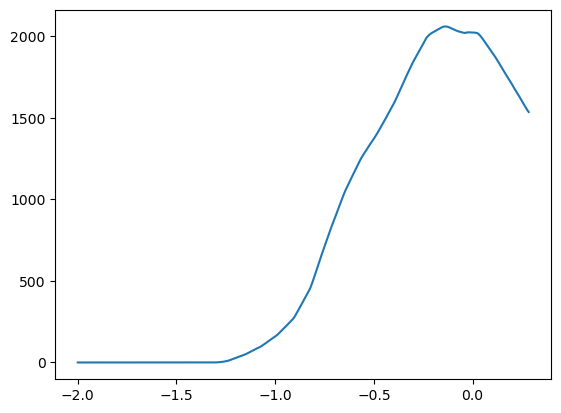

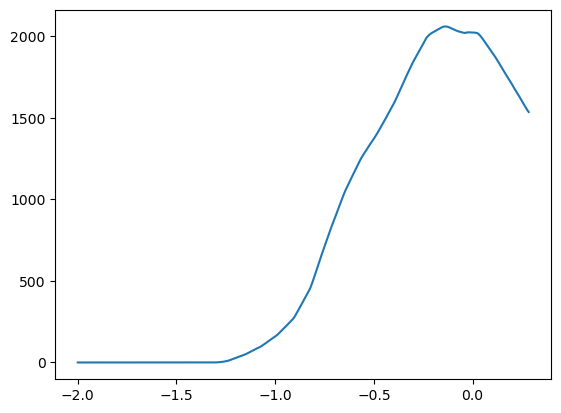

In [53]:
mean_inventory.plot()

In [126]:
y = std(fd_grid_obj_1).data_matrix.ravel()
x = grid_points
px.scatter(x=x, y=y)

In [124]:
mean_inventory.data_matrix.ravel()[500]

np.float64(0.0)

In [60]:
grid_points.shape

(2741,)

In [68]:
ends.collect()

shape: (3, 3)
┌───────────┬────────────┬─────────────────────┐
│ yr_diff   ┆ model_year ┆ predicted_inventory │
│ ---       ┆ ---        ┆ ---                 │
│ f64       ┆ i32        ┆ f64                 │
╞═══════════╪════════════╪═════════════════════╡
│ -0.078785 ┆ 2022       ┆ 935.574723          │
│ 0.283788  ┆ 2024       ┆ 1926.95002          │
│ -0.716411 ┆ 2025       ┆ 1169.16697          │
└───────────┴────────────┴─────────────────────┘

In [135]:
# Use the appropriately scaled 
# mean inventory curve for 2023 and 2024 to impute for 2022.

yr_diff_cutoff = (ends
    .filter(pl.col("model_year") == 2022)
    .select("yr_diff")
    .collect()
    .item()
)

mean_inventories = mean_inventory.data_matrix.ravel()
subset = mean_inventory.grid_points[0] < yr_diff_cutoff
extrapolations_1 = mean_inventories[subset]

# Determine the proper scaling factor.
scaling = ends.filter(pl.col("model_year") == 2022).select("predicted_inventory").collect().item() \
/ extrapolations_1[-1]


extrapolations_2 = scaling * extrapolations_1

mixed_years_3 = (mixed_years_2
    .with_columns(
        pl.lit(None).alias("extrapolation_method")
    )
)

mixed_years_3 = (mixed_years_3
    .filter((pl.col("model_year") == 2022) & (pl.col("predicted_inventory").is_nan()))
    .select("yr_diff", "model_year")
    .with_columns(
        pl.lit(pl.Series(extrapolations_2)).alias("predicted_inventory"),
        pl.lit("scaled_karcher_mean").alias("extrapolation_method")
    )
    .collect()
    .vstack(
        other=(mixed_years_3
            .filter((pl.col("model_year") != 2022) | (pl.col("predicted_inventory").is_not_nan()))
            .collect()
        )
    )
    .lazy()
)

In [141]:
mixed_years_3.collect()

shape: (20_112, 4)
┌───────────┬────────────┬─────────────────────┬──────────────────────┐
│ yr_diff   ┆ model_year ┆ predicted_inventory ┆ extrapolation_method │
│ ---       ┆ ---        ┆ ---                 ┆ ---                  │
│ f64       ┆ i32        ┆ f64                 ┆ str                  │
╞═══════════╪════════════╪═════════════════════╪══════════════════════╡
│ -2.0      ┆ 2022       ┆ 0.0                 ┆ scaled_karcher_mean  │
│ -1.999167 ┆ 2022       ┆ 0.0                 ┆ scaled_karcher_mean  │
│ -1.998333 ┆ 2022       ┆ 0.0                 ┆ scaled_karcher_mean  │
│ -1.9975   ┆ 2022       ┆ 0.0                 ┆ scaled_karcher_mean  │
│ -1.996666 ┆ 2022       ┆ 0.0                 ┆ scaled_karcher_mean  │
│ …         ┆ …          ┆ …                   ┆ …                    │
│ 2.186666  ┆ 2025       ┆ NaN                 ┆ null                 │
│ 2.1875    ┆ 2025       ┆ NaN                 ┆ null                 │
│ 2.188333  ┆ 2025       ┆ NaN                 ┆ null                 │
│ 2.189167  ┆ 2025       ┆ NaN                 ┆ null                 │
│ 2.19      ┆ 2025       ┆ NaN                 ┆ null                 │
└───────────┴────────────┴─────────────────────┴──────────────────────┘

## Compare to Simple Scaling Approach

In [147]:
scaling = (ratios
    .filter((pl.col("model_year") == 2022) & (pl.col("model_year_right") == 2023))
    .select("predicted_inventory_right_ratio")
    .collect()
    .item()
)

vals_to_scale = (mixed_years_3
    .filter((pl.col("model_year") == 2023) & (pl.col("yr_diff") < yr_diff_cutoff))
    .select("predicted_inventory")  
    .collect()
    .to_series()              
)

extrapolations = scaling * vals_to_scale

mixed_years_3 = (mixed_years_3
    .filter((pl.col("model_year") == 2022) & (pl.col("extrapolation_method") == "scaled_karcher_mean"))
    .with_columns(
        pl.lit(extrapolations).alias("predicted_inventory"),
        pl.lit("scaled_2023").alias("extrapolation_method")
    )
    .collect()
    .vstack(
        other=(mixed_years_3
            .collect()
        )
    )
    .lazy()
)

In [152]:
fig = px.scatter()
for yr in model_yr_range:
    # Make a plot of the original training data alongside the predictions.
    x_even = (mixed_years_3
        .filter((pl.col("model_year") == yr) & (pl.col("extrapolation_method").is_null()))
        .select("yr_diff")
        .collect()
        .to_series()
    )

    y_pred = (mixed_years_3
        .filter((pl.col("model_year") == yr) & (pl.col("extrapolation_method").is_null()))
        .select("predicted_inventory")
        .collect()
        .to_series()
    )

    fig.add_scatter(
        x=x_even,
        y=y_pred,
        mode="markers",
        name=f"{yr} Predicted"
    )

    x_even = (mixed_years_3
        .filter((pl.col("model_year") == yr) & (pl.col("extrapolation_method") == "scaled_karcher_mean"))
        .select("yr_diff")
        .collect()
        .to_series()
    )

    y_pred = (mixed_years_3
        .filter((pl.col("model_year") == yr) & (pl.col("extrapolation_method") == "scaled_karcher_mean"))
        .select("predicted_inventory")
        .collect()
        .to_series()
    )

    fig.add_scatter(
        x=x_even,
        y=y_pred,
        mode="markers",
        name=f"{yr} Predicted using scaled_karcher_mean"
    )

    x_even = (mixed_years_3
        .filter((pl.col("model_year") == yr) & (pl.col("extrapolation_method") == "scaled_2023"))
        .select("yr_diff")
        .collect()
        .to_series()
    )

    y_pred = (mixed_years_3
        .filter((pl.col("model_year") == yr) & (pl.col("extrapolation_method") == "scaled_2023"))
        .select("predicted_inventory")
        .collect()
        .to_series()
    )

    fig.add_scatter(
        x=x_even,
        y=y_pred,
        mode="markers",
        name=f"{yr} Predicted using scaled_2023"
    )

    x_original = (mixed_years
        .filter(pl.col("model_year") == yr)
        .select("yr_diff")
        .collect()
        .to_series()
    )

    y_act = (mixed_years
        .filter(pl.col("model_year") == yr)
        .select("advertised_inventory")
        .collect()
        .to_series()
    )

    fig.add_scatter(
        x=x_original,
        y=y_act,
        mode="markers",
        name=f"{yr} Actual"
    )

    # https://plotly.com/python/figure-labels/
    fig.update_layout(
        title=dict(text="Curve Fitting for Different Model Years"),
        xaxis=dict(
            title=dict(
                text="calendar_time - (model_year + 6/12) (years)"
            )
        ),
        yaxis=dict(
            title=dict(
                text="Advertised Vehicle Inventory (thousands)"
            )
        )
    )

fig.show()

In [ ]:
# Allowing the scaling of the Karcher template
# to extrapolate the 2022 curve to change over time.

# Consider graphing the coefficient of variation:
# standard devations divided by Karcher template means.

# Look at the proportion of the corresponding standard deviation
# that is needed to scale the 2022 curve to match the Karcher template.


In [492]:
fpca_obj = FPCA(
    n_components=4
)

fpca_obj.fit(
    X=fd_grid_obj
)

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

# Symbolic Regression

In [378]:
# https://gplearn.readthedocs.io/en/stable/advanced.html#custom-functions
def _logical(x1, x2, x3, x4):
    return np.where(x1 > x2, x3, x4)

logical = make_function(
    function=_logical,
    name='logical',
    arity=4
)

def _logistic(x):
    return 1 / (1 + np.exp(-x))

logistic = make_function(
    function=_logistic,
    name='logistic',
    arity=1
)

def _max0(x):
    return np.where(x > 0, x, 0)

max0 = make_function(
    function=_max0,
    name='max0',
    arity=1
)

# def _norm_kernel(x, mu, sigma):
#     return np.exp(-x**2)

# norm_kernel = make_function(
#     function=_norm_kernel,
#     name='norm_kernel',
#     arity=1
# )

def _raised_cosine_pdf(x: Array|float, mu: float=0.0, s: float=1.0):
    """https://en.m.wikipedia.org/wiki/Raised_cosine_distribution
    
    Args:
        s: positive real number
    """
    s = np.where(s < 1e-8, 1e-8, s)
    non_zero_pdf_val = 1.0/(2.0*s)*(1 + jnp.cos(np.pi * (x - mu)/s))
    pdf_vals = jnp.where(jnp.absolute(x - mu) > s, 0, non_zero_pdf_val)
    return pdf_vals

raised_cosine_pdf = make_function(
    function=_raised_cosine_pdf,
    name="raised_cosine_pdf",
    arity=3
)

sym_reg_obj = SymbolicRegressor(
    population_size=100,
    generations=100,
    tournament_size=50,
    function_set=[
        'add', 'mul', raised_cosine_pdf,
        max0, 'sub',
        # "abs",
        # 'div', "sin", "max", "inv", logistic, logical
    ],
    const_range=(-10.0, 10.0),
    parsimony_coefficient=1e-5,
    metric="mse",
    verbose=1
)

In [379]:
yr = 2023

X = (mixed_years_2
    .filter(pl.col("model_year") == yr)
    .select("yr_diff")
    .to_series()
    .to_numpy()
    .reshape((-1, 1))
)

y_scale_factor = 1500.0

y = (mixed_years_2
    .filter(pl.col("model_year") == yr)
    .select(pl.col("predicted_inventory") / y_scale_factor)
    .to_series()
    .to_numpy()
)

sym_reg_obj.fit(
    X=X,
    y=y
)

/home/justin/bin/mambaforge/envs/justins_room/lib/python3.11/site-packages/sklearn/base.py:474: FutureWarning:

`BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.



    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    53.09      5.12195e+29        9         0.124029              N/A     56.05s
   1    18.16      4.06707e+13        9        0.0626455              N/A     19.29s
   2     9.32           4.5509        9        0.0626455              N/A     14.75s
   3     8.76          2.13056       11        0.0535819              N/A     13.71s
   4     9.94      4.71405e+13       15        0.0515258              N/A     11.68s
   5    13.10      2.11463e+14       18        0.0490885              N/A     15.75s
   6    17.51      1.87967e+14       18        0.0455075              N/A     15.01s
   7    18.70      2.11463e+14       20        0.0453447              N/A     18.47s
   8    18.85       1.1748e+14       22        0.0452186              N/A  

SymbolicRegressor(const_range=(-10.0, 10.0),
                  function_set=['add', 'mul',
                                <gplearn.functions._Function object at 0x7558717b2ed0>,
                                <gplearn.functions._Function object at 0x75588ab35410>,
                                'sub'],
                  generations=100, metric='mse', parsimony_coefficient=1e-05,
                  population_size=100, tournament_size=50, verbose=1)

In [380]:
y_hat = y_scale_factor * sym_reg_obj.predict(
    X=X
)

fig = px.scatter()

fig.add_scatter(
    x=X.ravel(),
    y=y_hat,
    mode="markers",
    name="Symbolic Regression Predictions"
)

fig.add_scatter(
    x=X.ravel(),
    y=y_scale_factor * y,
    mode="markers",
    name="Inventory Curve"
)

fig.show()

In [ ]:
# Determine how to scale the inventory curve for model
# year 2023 to best match the inventory curve
# of model years 2022 and 2024.  
# Use the results to impute for model years 2022 and 2024.
# Determine the best scaling of the imputed curve for model year 2024 to
# match the curve for model year 2025.
# Use the reults to impute for model year 2025.
def raised_cosine_pdf(x: Array|float, mu: float=0.0, s: float=1.0):
    """https://en.m.wikipedia.org/wiki/Raised_cosine_distribution"""
    non_zero_pdf_val = 1.0/(2.0*s)*(1 + jnp.cos(np.pi * (x - mu)/s))
    pdf_vals = jnp.where(jnp.absolute(x - mu) > s, 0, non_zero_pdf_val)
    return pdf_vals

def stirlings_approx(n: Array|float):
    """Compute Stirling's approximation of n! to 2 orders.
    
    See: https://en.m.wikipedia.org/wiki/Stirling%27s_approximation
    """
    return jnp.sqrt(2*jnp.pi*n)*(n/jnp.e)**n * (1.0 + 1.0/(12.0 * n))

def stirlings_approx_gamma(z: Array|float, n: int=3):
    """Compute Stirling's approximation of Γ(z) to 2 orders.
    
    See: https://en.m.wikipedia.org/wiki/Stirling%27s_approximation
    Args:
        n: A non-negative integer.  Higher values should give more accuracy.  
            However, don't choose too high of a value or you will get
            overflow problems.
    """
    # See recurence formula: https://en.wikipedia.org/wiki/Gamma_function#Residues
    return stirlings_approx(z + n) / jnp.prod(z + jnp.arange(n + 1))
    
def symmetric_generalized_normal_pdf(x: Array|float, mu: float=0.0, alpha: float=1.0, beta: float=8.0):
    """https://en.m.wikipedia.org/wiki/Generalized_normal_distribution
    
    beta: positive
    """
    pdf_vals = beta/(2*alpha*stirlings_approx_gamma(1.0/beta))*jnp.exp(-(jnp.abs(x - mu)/alpha)**beta)
    return pdf_vals

def inventory_scaling_func(yr_diffs, params: Array):
    """
    params: Array with entries of `a`, `mu` and `s` (in that order)
    """
    a = params[0]
    mu = params[1]
    s = params[2]
    return 1.0 + a*raised_cosine_pdf(x=yr_diffs, mu=mu, s=s)

def inventory_scaling_func_2(yr_diffs, params: Array):
    """
    params: Array with entries of `a`, `mu`, `alpha`, and `beta` (in that order)
    """
    a = params[0]
    mu = params[1]
    alpha = params[2]
    beta = params[3]
    return 1.0 + a*symmetric_generalized_normal_pdf(x=yr_diffs, mu=mu, alpha=alpha, beta=beta)

def predict(yr_diffs, inventory, params):
    """
    params: Array with entries of `a`, `mu`, and `s` (in that order)
    """
    return inventory * inventory_scaling_func(yr_diffs=yr_diffs, params=params)

def predict_2(yr_diffs, inventory, params):
    """
    params: Array with entries of `a`, `mu`, `alpha`, and `beta` (in that order)
    """
    return inventory * inventory_scaling_func_2(yr_diffs=yr_diffs, params=params)

def mse(predicted: Array, actual: Array):
    n = len(actual)
    error = actual - predicted
    return (1.0/n * jnp.dot(error, error))

def loss(params: Array, yr_diffs, inventory, actual, constrained_index):
    """
    Args:
        params: `a`, `mu`, and `s`.
        constrained_index: either a 0 or a -1.  Used to indicate the
            entries in yr_diffs and inventory which should be predicted
            precisely.
    """
    predicted = predict(
        yr_diffs=yr_diffs,
        inventory=inventory,
        params=params
    )

    # print(f"actual[constrained_index]: {actual[constrained_index]}")
    # print(f"predicted[constrained_index]: {predicted[constrained_index]}")
    constraint_penalty = jnp.absolute(actual[constrained_index] - predicted[constrained_index])**3
    large_param_penalty = params[0]**2 + params[1]**2
    other_loss = mse(predicted=predicted, actual=actual)

    return constraint_penalty + large_param_penalty + other_loss

def loss_2(params: Array, yr_diffs, inventory, actual, constrained_index):
    """
    Args:
        params: Array with entries of `a`, `mu`, `alpha`, and `beta` (in that order)
        constrained_index: either a 0 or a -1.  Used to indicate the
            entries in yr_diffs and inventory which should be predicted
            precisely.
    """
    predicted = predict_2(
        yr_diffs=yr_diffs,
        inventory=inventory,
        params=params
    )

    # print(f"actual[constrained_index]: {actual[constrained_index]}")
    # print(f"predicted[constrained_index]: {predicted[constrained_index]}")
    constraint_penalty = jnp.absolute(actual[constrained_index] - predicted[constrained_index])**3
    large_param_penalty = params[0]**2 + params[1]**2
    other_loss = mse(predicted=predicted, actual=actual)

    return constraint_penalty + large_param_penalty + other_loss

@jit
def update(params, learning_rate, grad_loss, clip):
    # Prevent problems with exploding gradients using clipping.
    # https://arxiv.org/pdf/1211.5063
    grad_loss_mag = jnp.linalg.norm(grad_loss)
    grad_loss = cond(
        pred=(grad_loss_mag >= clip),
        true_fun=lambda x: clip/grad_loss_mag*x,
        false_fun=lambda x: x,
        operand=grad_loss
        
    )
    
    new_params = params - learning_rate * grad_loss
    return new_params

In [16]:
params = jnp.array([-1.6, -0.1, 1.5])

In [17]:
yr_diffs=(mixed_years_2
    .filter((pl.col("yr_diff").is_between(*yr_diff_filter[2022])) & (pl.col("yr_diff").is_between(*yr_diff_filter[2023])) & (pl.col("model_year") == 2022))
    .select("yr_diff")
    .to_series()
    .to_numpy()
)

inventory = (mixed_years_2
    .filter((pl.col("yr_diff").is_between(*yr_diff_filter[2022])) & (pl.col("model_year") == 2023))
    .select("predicted_inventory")
    .to_series()
    .to_numpy()
)

actual = (mixed_years_2
    .filter((pl.col("yr_diff").is_between(*yr_diff_filter[2022])) & (pl.col("yr_diff").is_between(*yr_diff_filter[2023])) & (pl.col("model_year") == 2022))
    .select("predicted_inventory")
    .to_series()
    .to_numpy()
)

preds = predict(
    yr_diffs=yr_diffs,
    inventory=inventory,
    params=params
)

for i in range(400):
    grad_loss = grad(loss)( 
        params,
        yr_diffs,
        inventory,
        actual,
        0
    )

    params = update(
        params=params,
        learning_rate=1e-8,
        grad_loss=grad_loss,
        clip=1e6
    )

    if i % 20 == 0:
        print(f"grad_loss {grad_loss}")
        print(f"params: {params}")

fig = px.scatter()

fig.add_scatter(
    x=(mixed_years_2
        .filter(pl.col("model_year") == 2023)
        .select("yr_diff")
        .to_series()
    ),
    y=(mixed_years_2
        .filter(pl.col("model_year") == 2023)
        .select("predicted_inventory")
        .to_series()
    ),
    mode="markers",
    name=f"2023 Predicted"
)

fig.add_scatter(
    x=(mixed_years_2
        .filter(pl.col("model_year") == 2022)
        .select("yr_diff")
        .to_series()
    ),
    y=actual,
    mode="markers",
    name=f"2022 Predicted"
)

fig.add_scatter(
    x=yr_diffs,
    y=preds
)

fig.show()

grad_loss [-3.4066066e+09  2.5418824e+08 -3.6300628e+09]
params: [-1.5931659  -0.10050994  1.5072825 ]
grad_loss [-1.6622984e+09  1.4626270e+08 -1.4745592e+09]
params: [-1.4497596  -0.11226591  1.6460913 ]
grad_loss [-7.2695475e+08  7.0944896e+07 -5.3446915e+08]
params: [-1.2944003  -0.12678711  1.7710887 ]
grad_loss [-2.4677971e+08  2.5153914e+07 -1.4868894e+08]
params: [-1.128388  -0.1434514  1.881244 ]
grad_loss [-38673716.    3863941.2 -18713132. ]
params: [-0.95307285 -0.16123244  1.9756933 ]
grad_loss [-36038.246    -435.6955 -16365.417 ]
params: [-0.83167297 -0.17271382  2.0297387 ]
grad_loss [-2783.495  -3660.5847 -2893.8176]
params: [-0.82958704 -0.17213006  2.030936  ]
grad_loss [ -301.08917 -3889.851   -1885.7783 ]
params: [-0.82936263 -0.1713668   2.0313804 ]
grad_loss [  151.42618 -3918.3416  -1695.611  ]
params: [-0.8293614 -0.1705847  2.0317326]
grad_loss [  249.49602 -3911.8672  -1648.1752 ]
params: [-0.82940435 -0.16980146  2.0320654 ]
grad_loss [  271.64365 -3898.0208

# Symmetric Generalized Normal Distribution

In [84]:
x = np.linspace(-3, 3, 100)
params_2 = np.array([-1.6, -0.1, 1.5, 9.2])    
y=inventory_scaling_func_2(yr_diffs=x, params=params_2)

px.line(
    x=x,
    y=y
)

In [85]:
yr_diffs=(mixed_years_2
    .filter((pl.col("yr_diff").is_between(*yr_diff_filter[2022])) & (pl.col("yr_diff").is_between(*yr_diff_filter[2023])) & (pl.col("model_year") == 2022))
    .select("yr_diff")
    .to_series()
    .to_numpy()
)

inventory = (mixed_years_2
    .filter((pl.col("yr_diff").is_between(*yr_diff_filter[2022])) & (pl.col("model_year") == 2023))
    .select("predicted_inventory")
    .to_series()
    .to_numpy()
)

actual = (mixed_years_2
    .filter((pl.col("yr_diff").is_between(*yr_diff_filter[2022])) & (pl.col("yr_diff").is_between(*yr_diff_filter[2023])) & (pl.col("model_year") == 2022))
    .select("predicted_inventory")
    .to_series()
    .to_numpy()
)

preds_2 = predict_2(
    yr_diffs=yr_diffs,
    inventory=inventory,
    params=params_2
)

# for i in range(200):
#     grad_loss_2 = grad(loss_2)( 
#         params_2,
#         yr_diffs,
#         inventory,
#         actual,
#         0
#     )

#     params_2 = update(
#         params=params_2,
#         learning_rate=1e-5,
#         grad_loss=grad_loss_2
#     )

#     if i % 50 == 0:
#         print(f"grad_loss_2 {grad_loss_2}")
#         print(f"params_2: {params_2}")

#         loss_2_val = loss_2(
#             params=params_2,
#             yr_diffs=yr_diffs,
#             inventory=inventory,
#             actual=actual,
#             constrained_index=0
#         )

#         print(f"loss_2: {loss_2_val}\n")

fig = px.scatter()

fig.add_scatter(
    x=(mixed_years_2
        .filter(pl.col("model_year") == 2023)
        .select("yr_diff")
        .to_series()
    ),
    y=(mixed_years_2
        .filter(pl.col("model_year") == 2023)
        .select("predicted_inventory")
        .to_series()
    ),
    mode="markers",
    name=f"2023 Predicted"
)

fig.add_scatter(
    x=(mixed_years_2
        .filter(pl.col("model_year") == 2022)
        .select("yr_diff")
        .to_series()
    ),
    y=actual,
    mode="markers",
    name=f"2022 Predicted"
)

fig.add_scatter(
    x=yr_diffs,
    y=preds_2
)

fig.show()

In [388]:
yr_diffs=(mixed_years_2
    .filter(pl.col("yr_diff").is_between(*yr_diff_filter[2023]))
    .select("yr_diff")
    .to_series()
    .to_numpy()
)

inventory = (mixed_years_2
    .filter(pl.col("yr_diff").is_between(*yr_diff_filter[2023]))
    .select("predicted_inventory")
    .to_series()
    .to_numpy()
)

preds_2b = predict_2(
    yr_diffs=yr_diffs,
    inventory=inventory,
    params=params_2
)

fig.add_scatter(
    x=yr_diffs,
    y=preds_2b,
    mode="markers"
)

fig.show()

In [390]:
len(preds_2b)

11817

# Metalog

Fit metalog PDF curves for each model year.  There can be a penalty for parameters being far from the parameters for 2023.  Do Vincent averaging to get one metalog PDF curve representative of all the model years.

In [264]:
inv_integral_2023 = cumulative_trapezoid(
    y=mixed_years_2
        .filter(pl.col("model_year") == 2023)
        .select("predicted_inventory")
        .to_series(),
    dx=step
)

inv_integral_2023_2 = inv_integral_2023 / inv_integral_2023[-1]

x=(mixed_years_2
    .filter(pl.col("model_year") == 2023)
    .select("yr_diff")
    .to_series()
    .to_numpy()[1:]
)

px.scatter(
    x=x,
    y=inv_integral_2023_2
)

In [265]:
p = inv_integral_2023_2[(inv_integral_2023_2 > 1e-5) & (inv_integral_2023_2 < (1 - 1e-5))]
num_rows = len(p)
x = x[(inv_integral_2023_2 > 1e-5) & (inv_integral_2023_2 < (1 - 1e-5))]

px.scatter(
    x=x,
    y=p
)

In [266]:
inv_integral_2023_2_filter = [(inv_integral_2023_2 > 1e-5) & (inv_integral_2023_2 < (1 - 1e-5))][::80]
p = inv_integral_2023_2[*inv_integral_2023_2_filter]
num_rows = len(p)
x=(mixed_years_2
    .filter(pl.col("model_year") == 2023)
    .select("yr_diff")
    .to_series()
    .to_numpy()[1:]
)
x = x[*inv_integral_2023_2_filter]

px.scatter(
    x=x,
    y=p
)

In [267]:
# https://blogs.sas.com/content/iml/2023/02/22/metalog-distribution.html

# Construct basis functions
# https://en.wikipedia.org/wiki/Metalog_distribution#Fitting_to_data
def g_i(i):
    if i == 1:
        g_i_func = lambda p: 1.0
    elif i == 2:
        g_i_func = lambda p: jnp.log(p/(1-p))
    elif i == 3:
        g_i_func = lambda p: (p - 0.5) * jnp.log(p/(1-p))
    elif i == 4:
        g_i_func = lambda p: p - 0.5
    elif (i % 2 == 1) and (i >= 5):
        g_i_func = lambda p: (p - 0.5)**((i - 1)/2)
    elif (i % 2 == 0) and (i >= 6):
        g_i_func = lambda p: (p - 0.5)**(i/2 - 1)
    
    return g_i_func


k = 100
@partial(jit, static_argnames=["k"])
def m(p, metalog_params, k):
    derivs_of_bases = jnp.array(
        list(grad(g_i(i))(p) for i in range(1, k + 1, 1))
    ).T
    return (metalog_params @ derivs_of_bases)**(-1)

M = np.array([
    [g_i(i=1)(p)]*num_rows,
    *list(g_i(i)(p) for i in range(2, k + 1, 1))
]).T
a = M.T @ M
b = M.T @ x
metalog_params_lstsq_result = np.linalg.lstsq(
    a=a,
    b=b
)
print(metalog_params_lstsq_result)
metalog_params = metalog_params_lstsq_result[0]

(array([-5.78131941e-02,  9.65578014e-02, -3.10571482e-02,  9.17505830e-01,
        1.26232463e+00,  1.26231090e+00, -5.27795257e+00, -5.27795132e+00,
       -4.00758890e+01, -4.00758891e+01,  8.85774554e+01,  8.85774554e+01,
        4.93686648e+02,  4.93686648e+02, -4.90894284e+02, -4.90894284e+02,
       -2.32896352e+03, -2.32896352e+03,  7.26630438e+02,  7.26630438e+02,
        3.05640858e+03,  3.05640858e+03,  7.26214613e+02,  7.26214613e+02,
        2.83950045e+03,  2.83950045e+03,  3.88073853e+02,  3.88073853e+02,
        1.44348701e+03,  1.44348701e+03,  1.60545197e+02,  1.60545197e+02,
        5.76277706e+02,  5.76277706e+02,  5.76369818e+01,  5.76369818e+01,
        2.01576273e+02,  2.01576273e+02,  1.89210987e+01,  1.89210987e+01,
        6.49178745e+01,  6.49178745e+01,  5.84401511e+00,  5.84401511e+00,
        1.97714529e+01,  1.97714529e+01,  1.72768610e+00,  1.72768610e+00,
        5.78676329e+00,  5.78676329e+00,  4.94349967e-01,  4.94349967e-01,
        1.64452155e+00, 

In [268]:
inventory = np.empty(shape = (len(p),))
i = 0
for cum_prob in p:
    inventory[i] = m(p=cum_prob, metalog_params=metalog_params, k=k)
    i += 1

In [269]:
def loss(scaling_factor: float, params: Array, yr_diffs, inventory, actual):
    """
    Args:
        params: 
    """
    other_loss = mse(predicted=scaling_factor * inventory, actual=actual)

    return other_loss

In [270]:
scaling_factor = 1678.3

actual = (mixed_years_2
    .filter(pl.col("model_year") == 2023)
    .select("predicted_inventory")
    .to_series()
    .to_numpy()
)[1: ][(inv_integral_2023_2 > 1e-5) & (inv_integral_2023_2 < (1 - 1e-5))][::100]

for i in range(150):
    grad_loss = grad(loss)( 
        scaling_factor,
        params,
        yr_diffs,
        inventory,
        actual
    )

    scaling_factor = update(
        params=scaling_factor,
        learning_rate=1,
        grad_loss=grad_loss,
        clip=1e6
    )

    if i % 20 == 0:
        print(f"grad_loss {grad_loss}")
        print(f"scaling_factor: {scaling_factor}")
print(scaling_factor)

fig = px.scatter()

fig.add_scatter(
    x=x,
    y=scaling_factor*inventory,
    mode="markers"
)

fig.add_scatter(
    x=x,
    y=actual,
    mode="markers"
)

fig.show()

TypeError: sub got incompatible shapes for broadcasting: (40,), (3996,).

## Metalog 2022

In [ ]:
0.4015 # yr_diff for 2022 median area-under-the-curve
yr_diffs=(mixed_years_2
    .filter((pl.col("yr_diff").is_between(*yr_diff_filter[2022])) & (pl.col("yr_diff").is_between(*yr_diff_filter[2023])) & (pl.col("model_year") == 2022))
    .select("yr_diff")
    .to_series()
    .to_numpy()
)

inventory = (mixed_years_2
    .filter((pl.col("yr_diff").is_between(*yr_diff_filter[2022])) & (pl.col("model_year") == 2023))
    .select("predicted_inventory")
    .to_series()
    .to_numpy()
)

actual = (mixed_years_2
    .filter((pl.col("yr_diff").is_between(*yr_diff_filter[2022])) & (pl.col("yr_diff").is_between(*yr_diff_filter[2023])) & (pl.col("model_year") == 2022))
    .select("predicted_inventory")
    .to_series()
    .to_numpy()
)

preds = predict(
    yr_diffs=yr_diffs,
    inventory=inventory,
    params=params
)

for i in range(400):
    grad_loss = grad(loss)( 
        params,
        yr_diffs,
        inventory,
        actual,
        0
    )

    params = update(
        params=params,
        learning_rate=1e-8,
        grad_loss=grad_loss,
        clip=1e6
    )

    if i % 20 == 0:
        print(f"grad_loss {grad_loss}")
        print(f"params: {params}")

# Kernel

In [15]:
fig = px.scatter()
yr_diffs_to_use = dict()
rel_dist_from_2023_pred_inventory = dict()

for yr in range(2022, 2026, 1):
    # We can only compare to 2023 at common times.
    yr_diffs_to_use[yr] = {
        "for_comparison": (mixed_years_2
            .filter((pl.col("model_year") == 2023) & pl.col("yr_diff").is_between(
                max(yr_diff_filter[yr][0], yr_diff_filter[2023][0]), 
                min(yr_diff_filter[yr][1], yr_diff_filter[2023][1])))
            .select("yr_diff")
            .to_series()
            .to_numpy()
        ),
        # 2022 uses 2024
        # 
        "for_prediction": (mixed_years_2
            .filter((pl.col("model_year") == 2023) & pl.col("yr_diff").is_between(
                max(yr_diff_filter[yr][0], yr_diff_filter[2023][0]), 
                min(yr_diff_filter[yr][1], yr_diff_filter[2023][1])))
            .select("yr_diff")
            .to_series()
            .to_numpy()
        )
    }
    
    
    
    
    # Calculate the relative distance from model year 2023's predicted inventory
    # at each time point.
    preds_for_2023_to_use = (mixed_years_2
        .filter((pl.col("model_year") == 2023) & pl.col("yr_diff").is_in(yr_diffs_to_use[yr]))
        .select("predicted_inventory")
        .to_series()
    )

    rel_dist_from_2023_pred_inventory[yr] = np.absolute(
        np.subtract(
            preds_for_2023_to_use, 
            mixed_years_2
                .filter((pl.col("model_year") == yr) & pl.col("yr_diff").is_in(yr_diffs_to_use[yr]))
                .select("predicted_inventory")
                .to_series()
        )
    ) / (preds_for_2023_to_use + 200)
    
    fig.add_scatter(
        x=yr_diffs_to_use[yr],
        y=rel_dist_from_2023_pred_inventory[yr],
        mode="markers",
        name=f"{yr} Predicted"
    )
fig.show()

InvalidOperationError: 'is_in' cannot check for String values in Float64 data

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'filter' failed <---
FILTER [([(col("model_year")) == (2023)]) & (col("yr_diff").is_in([Series]))] FROM
  DF ["yr_diff", "model_year", "predicted_inventory", "predicted_inventory_derivative"]; PROJECT */4 COLUMNS

In [ ]:
rel_dist_from_2023_pred_inventory_2024_sub = rel_dist_from_2023_pred_inventory[2024].filter(yr_diffs_to_use[2024] >= yr_diffs_to_use[2022][0]).to_numpy()
rel_dist_from_2023_pred_inventory_2022_sub = rel_dist_from_2023_pred_inventory[2022].filter(yr_diffs_to_use[2022] <= yr_diffs_to_use[2024][-1]).to_numpy()
yr_diffs_to_use_2024_sub = yr_diffs_to_use[2024].filter(yr_diffs_to_use[2024] >= yr_diffs_to_use[2022][0]).to_numpy()

rel_dist_from_2023_pred_inventory_2024_2022_avg = np.mean(
    rel_dist_from_2023_pred_inventory_2024_sub - rel_dist_from_2023_pred_inventory_2022_sub
)

np.float64(0.1838212070033685)

In [79]:
def normal_kernel(x: np.ndarray | float, mu: float=0.0, sigma: float=1.0) -> np.ndarray | float:
    """
    Parameters:
        
    """
    return np.exp(-((x - mu)**2)/(2 * sigma**2))

def weighted_avg(a:float, b:float, distances_from_a: np.ndarray | float, mu=0.0, sigma=1.0):
    a_weights = normal_kernel(x=distances_from_a, mu=mu, sigma=sigma)
    b_weights = 1 - a_weights

    return a * a_weights + b * b_weights

In [89]:
rel_dist_from_2023_pred_inventory_2024_sub_last = rel_dist_from_2023_pred_inventory_2024_sub[-1]
yr_diffs = yr_diffs_to_use[2022].filter(yr_diffs_to_use[2022] > yr_diffs_to_use[2024][-1]).to_numpy()
distances_from_a = yr_diffs - min(yr_diffs)
avgs = weighted_avg(
    a=rel_dist_from_2023_pred_inventory_2024_sub_last,
    b=rel_dist_from_2023_pred_inventory_2024_2022_avg,
    distances_from_a=distances_from_a
)
    
a = preds_for_2023_to_use.filter(yr_diffs_to_use[2023] > yr_diffs_to_use[2024][-1]).to_numpy()
b = a - avgs*(a + 200)
b

ShapeError: filter's length: 4920 differs from that of the series: 1541

In [58]:
rel_dist_from_2023_pred_inventory_2024_sub = rel_dist_from_2023_pred_inventory[2024].filter(yr_diffs_to_use[2024] >= yr_diffs_to_use[2022][0]).to_numpy()
rel_dist_from_2023_pred_inventory_2022_sub = rel_dist_from_2023_pred_inventory[2022].filter(yr_diffs_to_use[2022] <= yr_diffs_to_use[2024][-1]).to_numpy()
yr_diffs_to_use_2024_sub = yr_diffs_to_use[2024].filter(yr_diffs_to_use[2024] >= yr_diffs_to_use[2022][0]).to_numpy()

X = np.column_stack((
    np.ones(shape=len(yr_diffs_to_use_2024_sub)),
    yr_diffs_to_use_2024_sub,
    rel_dist_from_2023_pred_inventory_2024_sub,
    # yr_diffs_to_use_2024_sub * rel_dist_from_2023_pred_inventory_2024_sub
))

res = sm.OLS(
    endog=rel_dist_from_2023_pred_inventory_2022_sub,
    exog=X
).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.841
Method:                 Least Squares   F-statistic:                     1155.
Date:                Wed, 02 Apr 2025   Prob (F-statistic):          2.86e-174
Time:                        10:09:49   Log-Likelihood:                 1475.2
No. Observations:                 436   AIC:                            -2944.
Df Residuals:                     433   BIC:                            -2932.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4539      0.051      8.878      0.000       0.353       0.554
x1            -0.1918      0.008    -25.309      0.000      -0.207      -0.177
x2            -0.1612      0.095     -1.701      0.090      -0.347       0.025
==============================================================================
Omnibus:                       42.662   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.202
Skew:                          -0.848   Prob(JB):                     2.80e-12
Kurtosis:                       2.767   Cond. No.                         311.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
yr_diffs_to_use_2024_sub_2 = yr_diffs_to_use[2024].filter(yr_diffs_to_use[2024] < yr_diffs_to_use[2022][0]).to_numpy()
rel_dist_from_2023_pred_inventory_2024_sub_2 = rel_dist_from_2023_pred_inventory[2024].filter(yr_diffs_to_use[2024] < yr_diffs_to_use[2022][0]).to_numpy()

X = np.column_stack((
    np.ones(shape=len(yr_diffs_to_use_2024_sub_2)),
    yr_diffs_to_use_2024_sub_2,
    rel_dist_from_2023_pred_inventory_2024_sub_2,
    # yr_diffs_to_use_2024_sub_2 * rel_dist_from_2023_pred_inventory_2024_sub_2
))

rel_dist_from_2023_pred_inventory_2022_pred = res.predict(exog=X)

In [60]:
px.scatter(
    x=np.concat((yr_diffs_to_use_2024_sub_2, yr_diffs_to_use_2024_sub)),
    y=np.concat((rel_dist_from_2023_pred_inventory_2022_pred, rel_dist_from_2023_pred_inventory_2022_sub))
)

In [ ]:
# Do kernel regression to get an average across all model years.
derivative_model_2 = KernelReg(
    endog=mixed_years_2.select("predicted_inventory_derivative").to_series().to_numpy(),
    exog=mixed_years_2.select("yr_diff").to_series().to_numpy(),
    var_type="c",
    reg_type="ll",
    bw=[0.04]
)
predicted_inventory_derivative, _ = derivative_model_2.fit()

In [20]:
fig = px.scatter()
fig.add_scatter(
    x=(mixed_years_2
        .select("yr_diff")
        .to_series()
    ),
    y=predicted_inventory_derivative,
    mode="markers",
    name=f"{yr}"
)

fig.update_layout(
    title=dict(text="Predicted Average Inventory Derivative"),
    xaxis=dict(
        title=dict(
            text="calendar_time - (model_year + 6/12) (years)"
        )
    ),
    yaxis=dict(
        title=dict(
            text="Predicted d[Advertised Vehicle Inventory]/dt (thousands/yr)"
        )
    )
)

# Show the figure
fig.show()

In [ ]:
np.trapezoid(y=mixed_years_2
           .filter(pl.col("model_year") == 2023)
           .select("predicted_inventory_derivative")
           .to_series().to_numpy(), dx=step)

np.float64(0.0018605435097924783)

In [ ]:
# Make sure that the predicted inventory derivative integrates to 0.


Now, adjust for the fact that in recent years, model years have been released earlier and earlier.  See [link](https://en.wikipedia.org/wiki/Model_year#:~:text=Model%20year%20followed%20with%20calendar,that%20the%20vehicle%20was%20manufactured.).

In 1935, the derivative of inventory can become positive at `calendar_time - (model_year + 6/12) = -0.417`.  In 1965, the derivative of inventory can become positive at `calendar_time - (model_year + 6/12) = -1.167`.

In [28]:
fig = px.scatter()
fig.add_scatter(
    x=(mixed_years_2
        .select("yr_diff")
        .to_series()
        + 0.5
    ),
    y=predicted_inventory_derivative,
    mode="markers",
    name=f"{yr}"
)

fig.update_layout(
    title=dict(text="Predicted Average Inventory Derivative (Adjusted)"),
    xaxis=dict(
        title=dict(
            text="calendar_time - (model_year + 6/12) (years)"
        )
    ),
    yaxis=dict(
        title=dict(
            text="Predicted d[Advertised Vehicle Inventory]/dt (thousands/yr)"
        )
    )
)

# Show the figure
fig.show()